In [1]:
import torch
from dataset import ImageDataLoadBuilder, visualize_example
from models import ConvNet
from sklearn.metrics import cohen_kappa_score
from torch import Tensor, nn, optim
from torchsummary import summary
from torchvision import transforms
from training import Trainer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")

In [3]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

In [4]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [5]:
builder = ImageDataLoadBuilder(
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

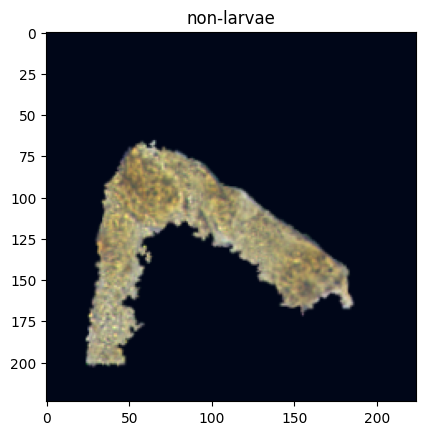

In [6]:
visualize_example(train_loader.dataset)

In [7]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(799, 319, 480)

In [8]:
model = ConvNet(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[7,14,28],
    use_dropout=True,
    use_batchnorm=True,
)
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 7, 224, 224]             189
       BatchNorm2d-2          [-1, 7, 224, 224]              14
              ReLU-3          [-1, 7, 224, 224]               0
         MaxPool2d-4          [-1, 7, 112, 112]               0
            Conv2d-5         [-1, 14, 112, 112]             882
       BatchNorm2d-6         [-1, 14, 112, 112]              28
              ReLU-7         [-1, 14, 112, 112]               0
         MaxPool2d-8           [-1, 14, 56, 56]               0
            Conv2d-9           [-1, 28, 56, 56]           3,528
      BatchNorm2d-10           [-1, 28, 56, 56]              56
             ReLU-11           [-1, 28, 56, 56]               0
        MaxPool2d-12           [-1, 28, 28, 28]               0
           Linear-13                  [-1, 128]       2,809,984
             ReLU-14                  [

In [9]:
def accuracy_fn(y_true, y_pred):
    y_pred_labels = y_pred.argmax(dim=1)
    return (y_pred_labels == y_true).float().mean().item()

def cohen_kappa_fn(y_true, y_pred):
    y_pred_labels = y_pred.argmax(dim=1)
    
    if len(torch.unique(y_true)) < 2:
        print("❗ Unique y_true.")
        kappa = 0.0
    elif len(torch.unique(y_pred_labels)) < 2:
        print("❗ Unique y_pred.")
        kappa = 0.0
    else:
        kappa = cohen_kappa_score(y_true.numpy(), y_pred_labels.numpy(), labels=[0, 1])

    return kappa

In [14]:
# criterion = nn.CrossEntropyLoss()
N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

In [15]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
checkpoint_path = "weights/model.pt"
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    scheduler=lr_scheduler,
    checkpoint_path=checkpoint_path,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [16]:
trainer.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.7916 | Val Loss: 0.6977 | Val cohen_kappa_fn: 0.0242 | Val accuracy_fn: 0.2226
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6598 | Val Loss: 0.6119 | Val cohen_kappa_fn: 0.1292 | Val accuracy_fn: 0.4671
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6007 | Val Loss: 0.5677 | Val cohen_kappa_fn: 0.1897 | Val accuracy_fn: 0.6332
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5689 | Val Loss: 0.5470 | Val cohen_kappa_fn: 0.2067 | Val accuracy_fn: 0.5987
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5656 | Val Loss: 0.5554 | Val cohen_kappa_fn: 0.1668 | Val accuracy_fn: 0.5266
  ❄️ Performance droped, model won't be saved!


📘 Epoch 6 | Train Loss: 0.5242 | Val Loss: 0.5031 | Val cohen_kappa_fn: 0.3596 | Val accuracy_fn: 0.7900
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4627 | Val Loss: 0.4762 | Val cohen_kappa_fn: 0.4466 | Val accuracy_fn: 0.8339
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4632 | Val Loss: 0.4348 | Val cohen_kappa_fn: 0.4406 | Val accuracy_fn: 0.8088
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4422 | Val Loss: 0.4446 | Val cohen_kappa_fn: 0.4271 | Val accuracy_fn: 0.7962
  ❄️ Performance droped, model won't be saved!


📘 Epoch 10 | Train Loss: 0.4360 | Val Loss: 0.4103 | Val cohen_kappa_fn: 0.6014 | Val accuracy_fn: 0.8840
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4101 | Val Loss: 0.3995 | Val cohen_kappa_fn: 0.4416 | Val accuracy_fn: 0.7962
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3844 | Val Loss: 0.3993 | Val cohen_kappa_fn: 0.3010 | Val accuracy_fn: 0.6771
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.3750 | Val Loss: 0.3570 | Val cohen_kappa_fn: 0.4337 | Val accuracy_fn: 0.7868
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.3241 | Val Loss: 0.3013 | Val cohen_kappa_fn: 0.5784 | Val accuracy_fn: 0.8715
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.3593 | Val Loss: 0.3713 | Val cohen_kappa_fn: 0.3701 | Val accuracy_fn: 0.7367
  ❄️ Performance droped, model won't be saved!


📘 Epoch 16 | Train Loss: 0.3371 | Val Loss: 0.2649 | Val cohen_kappa_fn: 0.6308 | Val accuracy_fn: 0.8934
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.3426 | Val Loss: 0.3846 | Val cohen_kappa_fn: 0.3320 | Val accuracy_fn: 0.7053
  ❄️ Performance droped, model won't be saved!


📘 Epoch 18 | Train Loss: 0.3021 | Val Loss: 0.2831 | Val cohen_kappa_fn: 0.5125 | Val accuracy_fn: 0.8401
  ❄️ Performance droped, model won't be saved!


📘 Epoch 19 | Train Loss: 0.3036 | Val Loss: 0.2721 | Val cohen_kappa_fn: 0.7065 | Val accuracy_fn: 0.9248
  ❄️ Performance droped, model won't be saved!


📘 Epoch 20 | Train Loss: 0.2929 | Val Loss: 0.2393 | Val cohen_kappa_fn: 0.6230 | Val accuracy_fn: 0.8903
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.2570 | Val Loss: 0.2513 | Val cohen_kappa_fn: 0.7065 | Val accuracy_fn: 0.9248
  ❄️ Performance droped, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2631 | Val Loss: 0.3369 | Val cohen_kappa_fn: 0.3880 | Val accuracy_fn: 0.7555
  ❄️ Performance droped, model won't be saved!


📘 Epoch 23 | Train Loss: 0.2884 | Val Loss: 0.2653 | Val cohen_kappa_fn: 0.6970 | Val accuracy_fn: 0.9216
  ❄️ Performance droped, model won't be saved!


📘 Epoch 24 | Train Loss: 0.2550 | Val Loss: 0.2256 | Val cohen_kappa_fn: 0.7162 | Val accuracy_fn: 0.9279
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.2487 | Val Loss: 0.2284 | Val cohen_kappa_fn: 0.6346 | Val accuracy_fn: 0.8903
  ❄️ Performance droped, model won't be saved!


📘 Epoch 26 | Train Loss: 0.2180 | Val Loss: 0.2122 | Val cohen_kappa_fn: 0.6635 | Val accuracy_fn: 0.9060
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.2343 | Val Loss: 0.2114 | Val cohen_kappa_fn: 0.6664 | Val accuracy_fn: 0.9091
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.2358 | Val Loss: 0.2232 | Val cohen_kappa_fn: 0.6137 | Val accuracy_fn: 0.8840
  ❄️ Performance droped, model won't be saved!


📘 Epoch 29 | Train Loss: 0.2184 | Val Loss: 0.2213 | Val cohen_kappa_fn: 0.6410 | Val accuracy_fn: 0.8997
  ❄️ Performance droped, model won't be saved!


📘 Epoch 30 | Train Loss: 0.2378 | Val Loss: 0.2275 | Val cohen_kappa_fn: 0.6289 | Val accuracy_fn: 0.8903
  ❄️ Performance droped, model won't be saved!


📘 Epoch 31 | Train Loss: 0.2143 | Val Loss: 0.2186 | Val cohen_kappa_fn: 0.6329 | Val accuracy_fn: 0.8966
  ❄️ Performance droped, model won't be saved!


📘 Epoch 32 | Train Loss: 0.2138 | Val Loss: 0.2244 | Val cohen_kappa_fn: 0.6664 | Val accuracy_fn: 0.9091
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


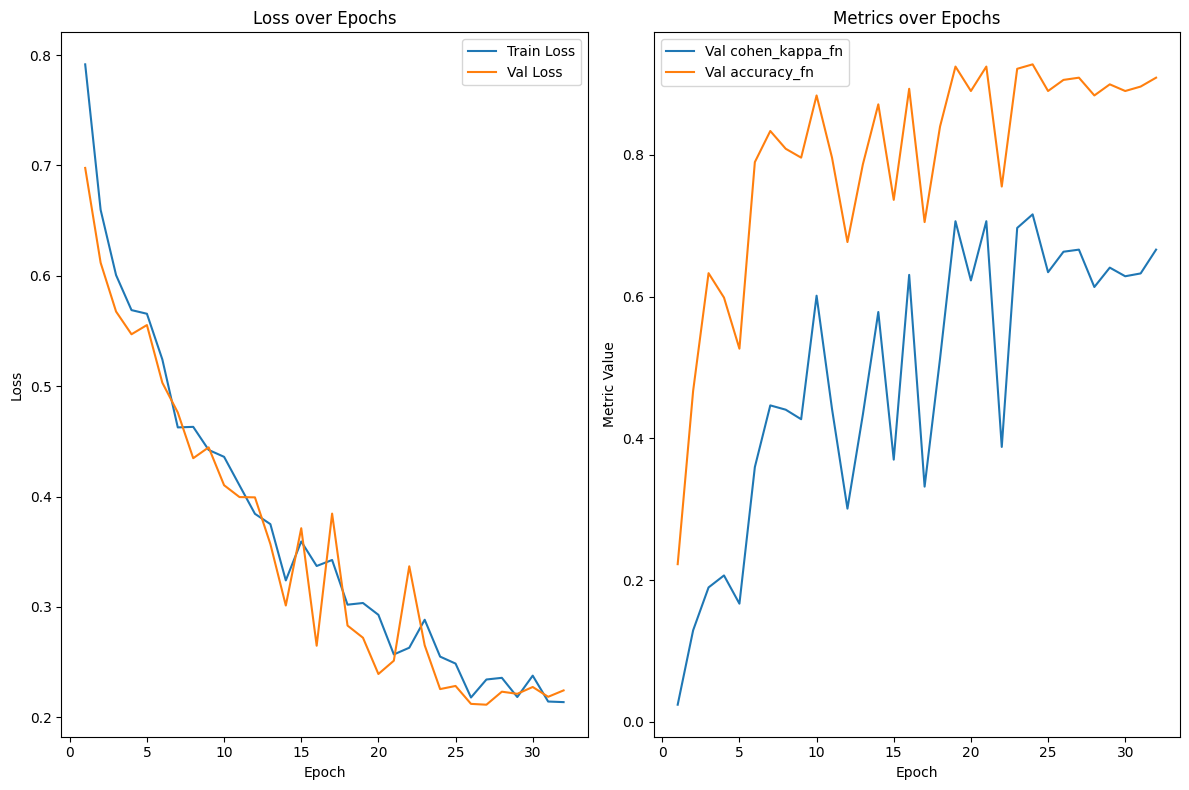

In [17]:
trainer.plot_epochs()

In [23]:
test_loss, test_metrics = trainer.evaluate(test_loader)
metrics_str = " | ".join(
    f"Test {name}: {value:.4f}"
    for name, value in zip(trainer.metric_names, test_metrics)
)
print(f"Test Loss: {test_loss:.4f} | {metrics_str}")

Test Loss: 0.2191 | Test cohen_kappa_fn: 0.7046 | Test accuracy_fn: 0.9208
